# Mining the Chinook Database with SQL and Python

In this project I'll be using SQL and Python together to mine a simple SQLite database to answer specific business questions.

### Helper Function
To assist with the interaction of these two languages, I'll create a helper function to run SQL queries in the Python environment. I'll use this to extract data from the database into Python dataframes, so it can then be further manipulated and visualised with Python as desired.


### Chinook Database
I'll be accessing the Chinook database, a sample data base representing a digital music store, with tables for artists, albums, media tracks, invoices and customers, created using real data from an iTunes Library.

More details about the Chinook database can be found [here](https://github.com/lerocha/chinook-database/tree/master/ChinookDatabase). A copy of the database schema can be found [here](https://github.com/lerocha/chinook-database/wiki/Chinook-Schema)

**Chinook Schema:**
![chinook_schema](chinook_schema_2.png)

Source: [Github](https://github.com/lerocha/chinook-database/wiki/Chinook-Schema)


## Create Helper Function to Quickly Execute SQL Queries
  
`run_query()`  
This will take an SQL query as an argument and return the results of that query in a pandas dataframe. It also makes use of a [context manager](https://jeffknupp.com/blog/2016/03/07/python-with-context-managers/) to open and close the database connection.

*Note:* As this function will be reading the results into a dataframe, this will be used exclusively for `SELECT` statements.

In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Create function to connect to DB, run query and return results in dataframe
def run_query(q):
    with sqlite3.connect('chinook.db') as conn:
        return pd.read_sql(q, conn)
    
# Test with query to return all tables and views in my database
test = '''
SELECT 
    name,
    tbl_name
FROM sqlite_master 
WHERE type IN ('table', 'view') 
ORDER BY type;
'''

run_query(test)

,name,tbl_name
0,album,album
1,artist,artist
2,customer,customer
3,employee,employee
4,genre,genre
5,invoice,invoice
6,invoice_line,invoice_line
7,media_type,media_type
8,playlist,playlist
9,playlist_track,playlist_track


## Task \#1: Album Recommendation

The store wants to add some new albums to sell to the US market. I've been given a list of 4 albums, all different genres, by different artists, and I need to decide which would be the best 3 to add to the store.

| Artist Name          | Genre   |
|:---------------------|:-------:|
| Regal                | Hip-Hop |
| Red Tone             | Punk    |
| Meteor and the Girls | Pop     |
| Slim Jim Bites       | Blues   |
  
None of the artists currently have any music in store, so I can't go off their past sales performance.  

Our target market is the USA, so decide to investigate what genres already perform well in the US market.

I extract data for total dollar value and percentage of the market held by the different genres of music in the US. 

In [2]:
q1 = '''
WITH dataset AS
    (
    SELECT 
        il.track_id, 
        quantity, 
        g.name genre
    FROM invoice_line il
    INNER JOIN invoice i ON il.invoice_id = i.invoice_id
    INNER JOIN track t ON il.track_id = t.track_id
    INNER JOIN genre g ON t.genre_id = g.genre_id
    WHERE i.billing_country = 'USA'
    )

SELECT 
    genre, 
    COUNT(*) sales_USA, 
    ROUND(COUNT(*)/CAST((SELECT COUNT(*) FROM dataset) AS FLOAT)*100, 2) perc_sales_USA
FROM dataset
GROUP BY genre
ORDER BY 2 DESC
;
'''
run_query(q1)

,genre,sales_USA,perc_sales_USA
0,Rock,561,53.38
1,Alternative & Punk,130,12.37
2,Metal,124,11.80
3,R&B/Soul,53,5.04
4,Blues,36,3.43
5,Alternative,35,3.33
6,Latin,22,2.09
7,Pop,22,2.09
8,Hip Hop/Rap,20,1.90
9,Jazz,14,1.33


Once I have this data I plot it.

Based on the results below for sales data of music genres in the USA, the 3 artists we should purchase, in order of genre performance, are:

1. Red Tone | Punk
2. Slim Jim Bites | Blues
3. Meteor and the Girls | Pop

*Note:* these 3 genres combined make up only 18% of total sales, whereas `Rock` as a genre on its own makes up over 53% of the market. 

We don't have any `Rock` artists in out pool to add to our store, it would be good to keep an eye out for some going forward.

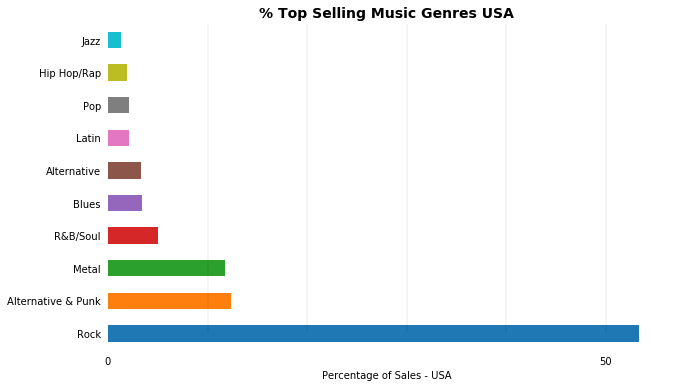

In [3]:
# Assign dataframe to variable name and plot
sales_USA = run_query(q1)
sales_USA.loc[:9].plot.barh(x='genre', y='perc_sales_USA', figsize=(10,6),
                            legend=False)

# Set labels, title
plt.ylabel('')
plt.xlabel('Percentage of Sales - USA')
plt.title('% Top Selling Music Genres USA', fontsize=14, fontweight='bold')

# Remove tick perams
plt.tick_params(bottom=False, top=False, left=False, right=False)

# Remove spines
for key, value in plt.gca().spines.items():
    value.set_visible(False)

# Set xticks
plt.xticks([0,50])

# Set vlines
plt.gca().vlines([10, 20, 30, 40, 50], ymin=0, ymax=10, alpha=0.05)
plt.savefig('chinook_music_usa.png')
plt.show()



## Task \#2: Analyse Employee Sales Performance

Each customer for the Chinook store gets assigned to a sales support rep within the company when they first make a purchase. 

It's now my job to analyze the purchases of customers belonging to each employee to see how sales support reps are performing relative to each other.


#### Note:
A few points to note with the Chinook database.
- Invoices date up to December 2020
- The link between sales agent and how much they have sold is sales rep -> customer -> invoice. *However*, as demonstrated below, I can see that there are invoices for customers of a particular rep existing from *before* that rep was hired. I assume that these customers were assigned to other reps before the current reps were hired, and made those purchases with these previous reps.

I only want to consider sales that were made by each rep *after* their hire date.

I will also want to get the total number of months with at least one successful sale for each rep, so that I can use this to calculate the average sale value per month. To assist with this I will convert the date format to `yyyy-mm`.

In [4]:
q2a='''

WITH sales AS
    (
        SELECT
            (e.first_name || " " || e.last_name) sales_rep,
            strftime("%Y-%m", e.hire_date) hire_date,
            strftime("%Y-%m", i.invoice_date) invoice_date
        FROM invoice i
        INNER JOIN customer c ON c.customer_id = i.customer_id
        INNER JOIN employee e ON e.employee_id = c.support_rep_id
    )
    
SELECT 
    s.sales_rep,
    s.hire_date,
    min(s.invoice_date) as customer_first_invoice,
    max(s.invoice_date) as customer_last_invoice,
    m.sales_months
FROM sales s
INNER JOIN 
    (
        SELECT 
            sales_rep,
            count(distinct(invoice_date)) sales_months
        FROM sales
        WHERE hire_date <= invoice_date
        GROUP BY 1
    ) m 
    ON m.sales_rep = s.sales_rep
GROUP BY 1
;

'''

run_query(q2a)

,sales_rep,hire_date,customer_first_invoice,customer_last_invoice,sales_months
0,Jane Peacock,2017-04,2017-01,2020-12,44
1,Margaret Park,2017-05,2017-01,2020-12,44
2,Steve Johnson,2017-10,2017-01,2020-12,37


Now that I have established actual number of months with at least one successful sale, let's look at sales rep performance.

I'll look at sales from a few different angles:

1. Total sales
2. Average monthly sales (mean)
3. Sales month to month 
4. Distribution of sales
5. Median monthly sales


#### 1. Total Sales to Date by Sales Rep

I group total sales by rep, only taking into account sales made after the rep hire date.

I can see that Jane is the highest performing rep with her sales making almost 37% of total sales. Her sales total is 9.6% greater than Margaret's, and 29.6% greater than Steve's.

She is one of the longer serving reps however, with 19% more months successfully worked than Steve.

       sales_rep  total_sales  sales_months  avg_monthly_sales
0   Jane Peacock      1536.48            44              34.92
1  Margaret Park      1401.84            44              31.86
2  Steve Johnson      1185.03            37              32.03


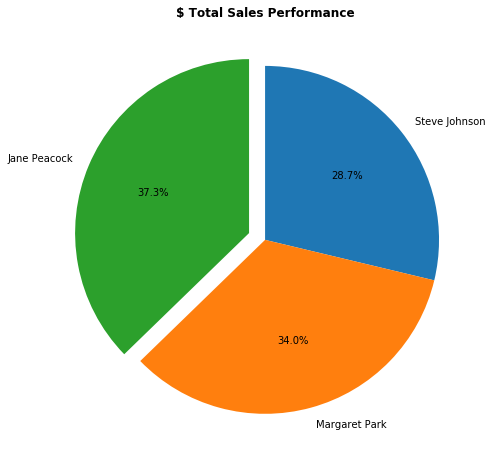

In [5]:
q2b='''

WITH sales AS
    (
        SELECT
            (e.first_name || " " || e.last_name) sales_rep,
            i.total,
            strftime("%Y-%m", e.hire_date) hire_date,
            strftime("%Y-%m", i.invoice_date) invoice_date
        FROM invoice i
        INNER JOIN customer c ON c.customer_id = i.customer_id
        INNER JOIN employee e ON e.employee_id = c.support_rep_id
    )

SELECT 
    s.sales_rep,
    sum(s.total) total_sales,
    m.sales_months,
    round((sum(s.total) / m.sales_months), 2) avg_monthly_sales
FROM sales s
INNER JOIN 
    (
        SELECT 
            sales_rep,
            count(distinct(invoice_date)) as sales_months
        FROM sales
        WHERE hire_date <= invoice_date
        GROUP BY 1
    ) m 
    ON m.sales_rep = s.sales_rep 
WHERE s.hire_date <= s.invoice_date
GROUP BY 1
;

'''
# print total sales and average monthly sales
print(run_query(q2b))

# Assign to variable name
sales_totals = run_query(q2b)

# Plot total sales data 
plt.figure(figsize=(8,8))
sales_pie = sales_totals.set_index('sales_rep')
sales_pie = sales_pie["total_sales"].copy().rename('')
explode = (0, 0, 0.1) 
sales_pie.sort_values().plot.pie(
    startangle=90,
    counterclock=False,
    autopct='%1.1f%%',
    explode = explode
)
plt.title('$ Total Sales Performance', fontsize=12, fontweight='bold')
plt.savefig('chinook_total_perf.png')
plt.show()


#### 2. Average Monthly Sales by Sales Rep

I decide to look at each rep's mean monthly sales to make a fairer comparison, diving total sales by the number of months with at least 1 successful sale made.

From this perspective Jane is top of the leader board again. I can see that on average, Jane sells roughly 9 - 9.6% more per month than her colleagues. However, we don't know if the mean is the best statistic to use to give us the most representative or typical sales value for each rep.

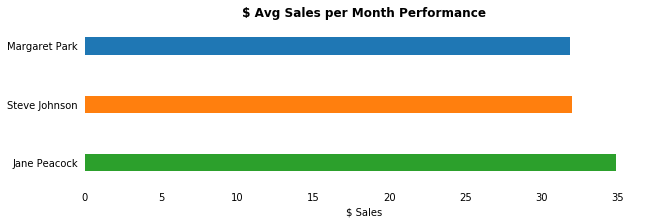

In [6]:
# Order dataframe by avg_monthly_sales
sales_totals.sort_values('avg_monthly_sales', inplace=True)

# Plot average monthy sales
sales_totals.plot.barh(x='sales_rep', y='avg_monthly_sales', legend=False, width=0.3, figsize=(10,3))

# Remove tick params and spines
plt.tick_params(bottom=False, top=False, left=False, right=False)
for key, value in plt.gca().spines.items():
    value.set_visible(False)
plt.gca().invert_yaxis()
plt.ylabel('')
plt.xlabel('$ Sales')
plt.title('$ Avg Sales per Month Performance', fontsize=12, fontweight='bold')
plt.savefig('chinook_month_perf.png')
plt.show()

#### 3. Actual Sales Month to Month

Let's see how the reps perform relative to each other for any given month. I get all the sales data for reps grouped by month and plot it on a line graph.

However, I can see **in this format** the results are **not the easiest** to interpret and draw conclusions from.

Nor do they give us any sense of how the reps perform overall relative to each other.

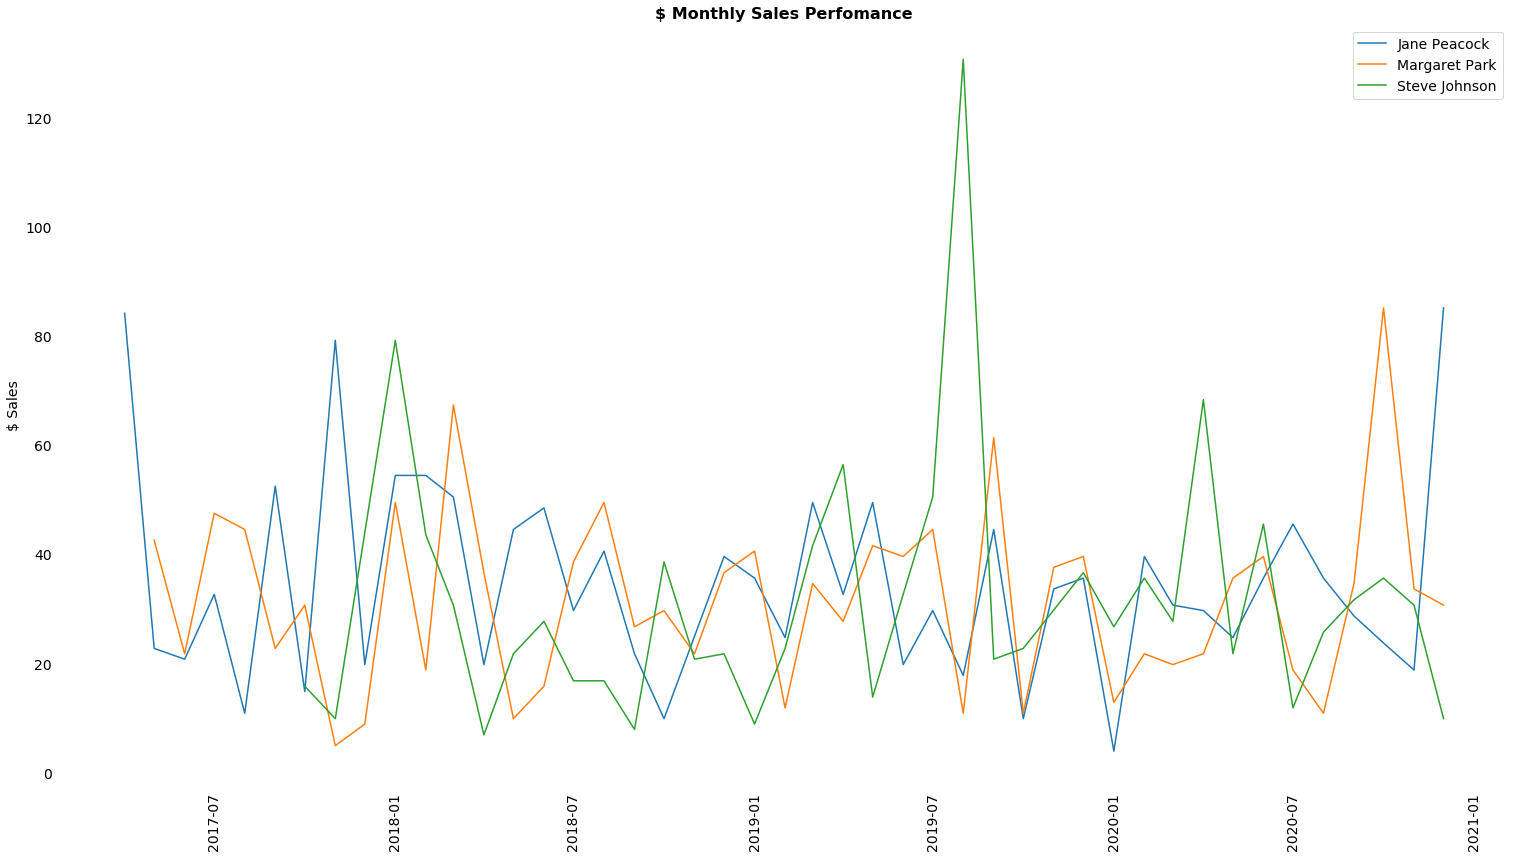

In [7]:
# Get total sales grouped by rep and sales month

q2c='''

WITH sales AS
    (
        SELECT
            (e.first_name || " " || e.last_name) sales_rep, 
            i.total as sale, 
            strftime("%Y-%m", i.invoice_date) invoice_date
        FROM invoice i
        INNER JOIN customer c ON c.customer_id = i.customer_id
        INNER JOIN employee e ON e.employee_id = c.support_rep_id
        WHERE e.hire_date <= i.invoice_date
    )

SELECT 
    sales_rep,
    sum(sale) as monthly_sales,
    invoice_date
FROM sales
GROUP BY 1, 3
ORDER BY 1, 3
;

'''

# Assign dataframe to variable name
monthly_sales = run_query(q2c)

# Format date column to datetime
monthly_sales['invoice_date']  = pd.to_datetime(monthly_sales['invoice_date'])

# List of reps
reps = monthly_sales['sales_rep'].unique()

# Plot sales
plt.figure(figsize=(26,14))

for rep in reps:
    plt.plot(monthly_sales.loc[monthly_sales['sales_rep'] == rep, 'invoice_date'], 
          monthly_sales.loc[monthly_sales['sales_rep'] == rep, 'monthly_sales'], label = rep)

# Remove tick params adnd spines
plt.tick_params(bottom=False, top=False, left=False, right=False)
for key, value in plt.gca().spines.items():
    value.set_visible(False)

plt.xticks(rotation=90, fontsize=14)
plt.yticks(fontsize=14)
plt.legend(prop={'size': 14})
plt.ylabel('$ Sales', fontsize=14)
plt.title('$ Monthly Sales Perfomance', fontsize=16, fontweight='bold')
plt.savefig('chinook_monthly.png')
plt.show()


#### 4. Distribution of Sales Values
Let's take a look at the distributions of sales made instead.

I'll display the median monthly sales value as well. I'm choosing median as the most representative value as I can see all three distributions are somewhat skewed, and the median is a robust statistic, resistant to the pull of outliers.

From the below we immediately have a more of a granular understanding of the distributions of the monthly sales values for each rep. 

We can see that Steve's monthly average is skewed by one very large sales month. So the \$32.03 value we calculated above as his mean value is not really representative of his typical monthly sale value.

We can also see that Margaret's most frequent monthly sales values are higher than both her colleagues' most frequent monthly sales values. Jane's most frequent monthly sale values are higher than Steven's.

We can also see where their sales fall relative to the group's `average` monthly sale value. Let's take a closer look at how many of their sales are above or below the group's average.

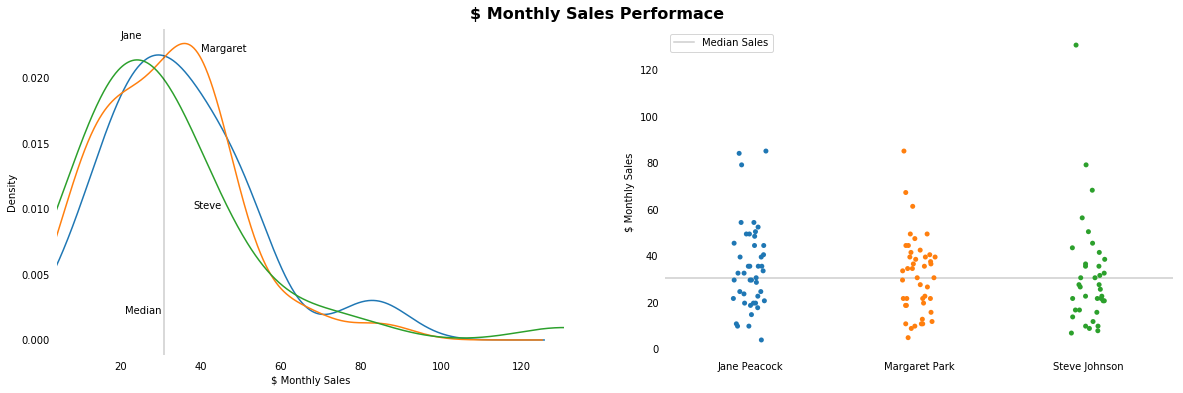

In [8]:
# Plot figure with 2 axes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
ax1, ax2 = axes.flatten()
fig.suptitle('$ Monthly Sales Performace', y=.93, fontsize=16, fontweight='bold')

## ax1 = kde
for rep in reps:
    monthly_sales.loc[monthly_sales['sales_rep'] == rep, 'monthly_sales'].plot.kde(label=rep, ax=ax1)
ax1.set_xlabel('$ Monthly Sales')
ax1.set_xlim(monthly_sales['monthly_sales'].min(), monthly_sales['monthly_sales'].max())
ax1.axvline(monthly_sales['monthly_sales'].median(), color = 'k', alpha=0.2, label = 'Median')

# Annotate
ax1.text(21, .002, 'Median')
ax1.text(20, .023, 'Jane')
ax1.text(40, .022, 'Margaret')
ax1.text(38, .01, 'Steve')

# Remove tick params and spines
ax1.tick_params(top=False, right=False, left=False, bottom=False)
for key, value in ax1.spines.items():
    value.set_visible(False)

## ax2 = stripplot
import seaborn as sns
sns.stripplot(x='sales_rep', y='monthly_sales', data=monthly_sales, jitter=True, ax=ax2)
ax2.set_xlabel('')
ax2.set_ylabel('$ Monthly Sales')
ax2.axhline(monthly_sales['monthly_sales'].median(), color='k', alpha=0.2, label='Median Sales')

# Remove tick params and spines
ax2.tick_params(top=False, right=False, left=False, bottom=False)
for key, value in ax2.spines.items():
    value.set_visible(False)

plt.legend(loc='upper left')
plt.savefig('chinook_distros_a.png')
plt.show()


We can see below that both Jane and Margaret perform above the group's median monthly sales value roughly 50% of the time, and below the median monthly sales value roughly 50% of the time.

Steve performs below the median monthly sales value 62% of the time, with 23 out of his 37 months landing below the group's average.

In [9]:
# Get count of months above and below group average value for each rep
median = monthly_sales['monthly_sales'].median()

# Store reps and count of months above/below median
months_above_median = {}
months_below_median = {}

for rep in reps:
    month_above = monthly_sales[(monthly_sales['sales_rep'] == rep) & (monthly_sales['monthly_sales'] > median)].shape[0]
    month_below = monthly_sales[(monthly_sales['sales_rep'] == rep) & (monthly_sales['monthly_sales'] <= median)].shape[0]
    months_above_median[rep] = month_above
    months_below_median[rep] = month_below    
    
median_df = pd.DataFrame(pd.Series(months_above_median), columns=['months_above_median'])
median_df['months_below_median'] = pd.DataFrame(pd.Series(months_below_median))

median_df

,months_above_median,months_below_median
Jane Peacock,23,21
Margaret Park,22,22
Steve Johnson,14,23


#### 5. Median Monthly Sales  
I'll perform one last analysis. 

As we saw above, each rep has a slightly skewed sales distribution. Given this, the median is a better statistic to use as the typical monthly sale value for each rep. I'll get the median monthly sale value of each rep and compare.

Steve again has the lowest typical value. Jane's typical monthly sale value is the highest, just beating Margaret's.

In [10]:
rep_medians = {}
for rep in reps:
    rep_median = monthly_sales.loc[monthly_sales['sales_rep'] == rep, 'monthly_sales'].median()
    rep_medians[rep] = rep_median
rep_medians

{'Jane Peacock': 32.67,
 'Margaret Park': 32.175000000000004,
 'Steve Johnson': 26.729999999999997}

From all the above analysis I can conclude:
- Steve is the worst performing rep
    - His most frequent sales are of low value relative to those of his colleagues
    - The large majority of his sales are below the group average sales value
    - He has the lowest typical monthly sale value
    
- There is really not much to chose between Jane's and Margaret's performances
    - Margaret's most frequent sales are the highest value of the group, so she may be viewed as the most 'reliable' high performer
    - Jane has gotten the highest total value of sales, with the help of a small number of higher value sales compared to her colleagues, however her most frequent monthly sale values are lower than Margaret's
    - Jane's typical monthly sales performance is just higher than Margaret's

## Task 3: Analysing Sales by Country

I'm looking for growth opportunities in different markets, so I decide to investigate sales by country level. In particular I'm going to look at, for each country:
- Total number of customers
- Total value of sales
- Average value of sales per customer
- Average order value

There are a number of countries with only one customer. I'm going to group these countries as `Other`, and force these `Other` customers to the bottom of my results, which will otherwise be sorted by the average customer spend from highest to lowest.

In [11]:
# Rename countries with 1 customer as 'Other'
# Push 'Other' down to the bottom of results

q3 = '''
WITH dataset AS
    (
        SELECT
            CASE
                 WHEN n.customer_count = 1 THEN 'Other'
                 ELSE c.country
            END AS other,
            c.country,
            c.customer_id,
            i.total,
            i.invoice_id
        FROM customer c
        INNER JOIN
            (
                SELECT 
                    country, 
                    count(customer_id) customer_count
                FROM customer
                GROUP BY 1
            ) n ON n.country = c.country
        INNER JOIN invoice i ON i.customer_id = c.customer_id
    )

SELECT 
    other country, 
    count(distinct customer_id) total_customers,
    sum(total) total_sales,
    round(sum(total)/count(distinct customer_id), 2) avg_customer_spend,
    round(sum(total)/count(distinct invoice_id), 2) avg_order_value
FROM 
    (
        SELECT
            *,
            CASE
                WHEN other = 'Other' THEN 1
                ELSE 0
            END AS sort
        FROM dataset
    )
GROUP BY other
ORDER BY sort, avg_customer_spend DESC
;
'''

run_query(q3)

,country,total_customers,total_sales,avg_customer_spend,avg_order_value
0,Czech Republic,2,273.24,136.62,9.11
1,Portugal,2,185.13,92.57,6.38
2,India,2,183.15,91.57,8.72
3,Brazil,5,427.68,85.54,7.01
4,Germany,4,334.62,83.66,8.16
5,United Kingdom,3,245.52,81.84,8.77
6,USA,13,1040.49,80.04,7.94
7,France,5,389.07,77.81,7.78
8,Canada,8,535.59,66.95,7.05
9,Other,15,1094.94,73.00,7.45


Now let's plot this data.

I'm looking for opportunities in different markets, so I want to find countries with customers demonstrating high value spending habits.

From the below I can see that the **Czech Republic**, **India** and **the UK** might be of interest. On average relative to the existing customer base they have high spend per customer, high value individual orders, and good customer lifetime value. 

Of course, our population here is very small. However, based on these results, the above are the countries I would put forward as warranting further investigation as potential markets. 

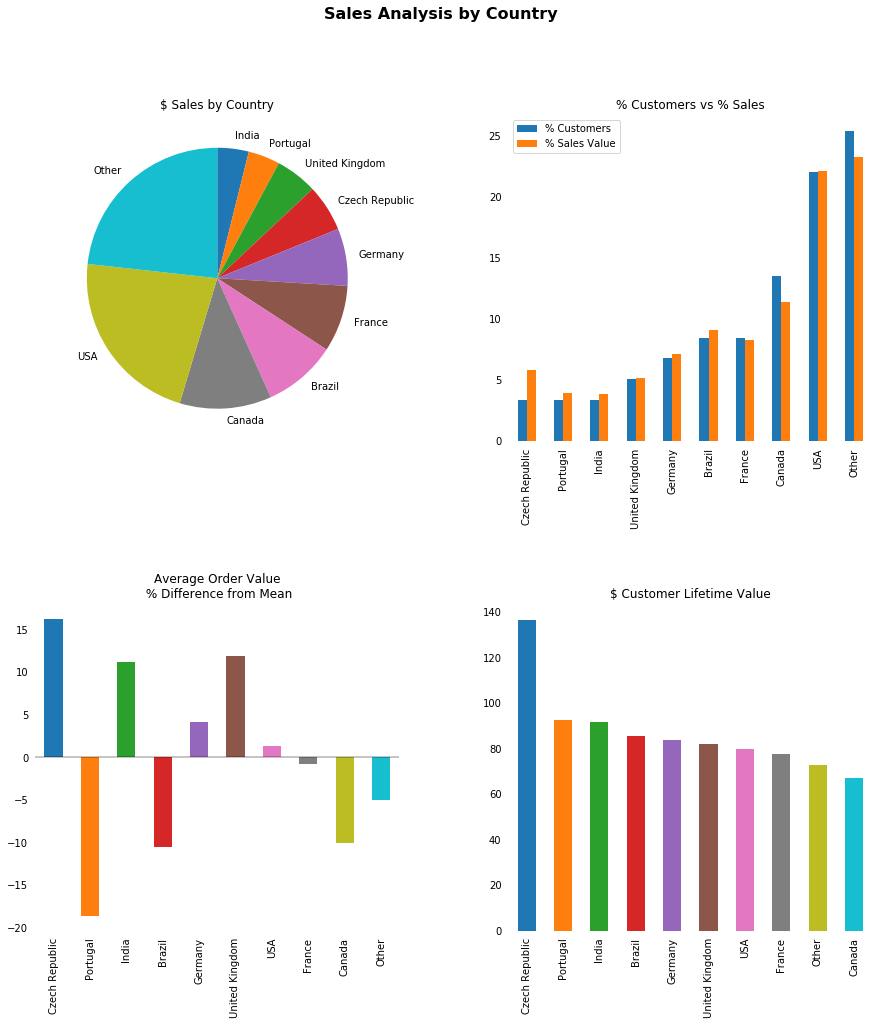

In [12]:
import numpy as np

# Assign dataframe, make country index, remove index header
country_sales = run_query(q3)
country_sales.set_index("country", drop=True, inplace=True)
country_sales.index.name= ''

# Initialise figure and axes
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))
ax1, ax2, ax3, ax4 = axes.flatten()
fig.subplots_adjust(hspace=.5, wspace=.3)
fig.suptitle('Sales Analysis by Country', fontsize=16, fontweight='bold')

## ax1 - pie plot of total sales $
# Remove column name
sales_breakdown = country_sales["total_sales"].copy().rename('')
sales_breakdown.sort_values().plot.pie(
    ax=ax1,
    startangle=90,
    counterclock=False,
    title='$ Sales by Country'    
)


## ax2 - compare % customers to % sale value
customers_sales = country_sales[['total_customers', 'total_sales']].copy()

# Get values as %
customers_sales['total_customers'] /= customers_sales['total_customers'].sum() / 100
customers_sales['total_sales'] /= customers_sales['total_sales'].sum() / 100

# Rename for legend
customers_sales.rename({'total_customers' : '% Customers', 'total_sales' : '% Sales Value'}, axis = 1, inplace=True)

# Plot
customers_sales.sort_values('% Customers').plot.bar(
    ax=ax2,
    title="% Customers vs % Sales"
)
ax2.tick_params(top=False, right=False, left=False, bottom=False)
for value in ax2.spines.values():
    value.set_visible(False)


## ax3 - Average order value, difference from the mean
avg_order = country_sales['avg_order_value'].copy()

# Get % above the mean
difference_from_avg = (avg_order / avg_order.mean() * 100) - 100

# Plot
difference_from_avg.plot.bar(
    ax=ax3,
    title="Average Order Value\n % Difference from Mean"
)

# Remove tick params and spines
ax3.tick_params(top=False, right=False, left=False, bottom=False)
ax3.axhline(0, color='k', alpha=0.3)
for value in ax3.spines.values():
    value.set_visible(False)


## ax4 - average cusotmer spend as customer lifetime value
ltv = country_sales["avg_customer_spend"].copy()

# Plot
ltv.sort_values(ascending=False).plot.bar(
    ax=ax4,
    title = '$ Customer Lifetime Value'
)

# Remove tick params and spines
ax4.tick_params(top=False, right=False, left=False, bottom=False)
for value in ax4.spines.values():
    value.set_visible(False)
    
plt.savefig('chinook_countries.png')
plt.show()

## Task #4: Albums vs Individual Tracks

In a transaction, customers can purchase music in one of two ways:
- Purchase individual tracks 
- Purchase an entire album

Customers do not have the option to combine these methods, i.e. they are unable to purchase an album and also purchase individual tracks in the same transaction.

Management are considering lowering their costs by not purchasing entire albums, but instead only buying the more popular tracks off an album.

It's my job to explore the behaviour of the market. What proportion of purchases are whole-album purchases vs a collection of individual tracks purchases?

To do this I will compare invoices and albums
- Take the first track on the invoice
- Get the album it belongs to
- Compare all tracks on the album with all tracks on the invoice
- If there is a full match without exceptions they I can say it was a full album purchase

#### Results
From the below I can see that 81% of purchases were collections of individual tracks, and 19% were whole-album purchases.

If management were to change purchasing strategy to purchasing individual tracks only, they would be failing to cater to almost one fifth of their market. 

In this case, my recommendation is that further analysis should be done to determine if the cost savings from changing purchasing strategy would outweigh the potential revenue loss from these album-buying customers.

In [13]:
q4 = '''
WITH 
album_invoice AS
    (
        SELECT 
            t.album_id,
            n.invoice_id,
            n.invoice_track_id
        FROM track t
        INNER JOIN 
            (
                SELECT 
                    il.invoice_id,
                    min(il.track_id) as invoice_track_id
                FROM invoice_line il
                INNER JOIN track t ON il.track_id = t.track_id
                GROUP BY 1
            ) n ON n.invoice_track_id = t.track_id
    ),

compare_tracks AS
    (
        SELECT 
            ai.*,
            CASE
                WHEN
                    (
                        SELECT t.track_id from track t
                        where t.album_id = ai.album_id
                        
                        EXCEPT
                        
                        SELECT il.track_id from invoice_line il
                        where il.invoice_id = ai.invoice_id
                    )  IS NULL
                    
                    AND
                    (
                        SELECT il.track_id from invoice_line il
                        where il.invoice_id = ai.invoice_id
                        
                        EXCEPT
                        
                        SELECT t.track_id from track t
                        where t.album_id = ai.album_id
                                                
                    )  IS NULL
                THEN "Yes"
                ELSE "No"
            END AS "album_purchased"
        FROM album_invoice ai
    )

SELECT 
    album_purchased,
    COUNT(invoice_id) no_of_purchases,
    ROUND(cast(count(invoice_id) as float)/(select count(*) from invoice)*100, 2) percentage
FROM compare_tracks
GROUP BY 1
;
'''

run_query(q4)

,album_purchased,no_of_purchases,percentage
0,No,500,81.43
1,Yes,114,18.57


# Conclusion

In this project I combined SQL and Python to mine, analyse and manipulate data from a database.

I created a helper function in Python to manages the connection to the database, passing in the SQL query and outputting the results in a pandas dataframe.

I wrote SQL queries to retrieve data to answer complex and particular business questions. 

I then created tables and visualisations to assist in presenting my findings and give my recommendations.